# Import necessary packages

In [1]:
from time import time
import logging
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import tensorflow as tf

from tensorflow import keras

from tensorflow.keras import layers

import numpy as np
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, Convolution2D, LocallyConnected2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

import numpy as np
import os
from os import listdir
from skimage.io import imread, imshow

import seaborn as sns

from sklearn.metrics import ConfusionMatrixDisplay

# load images and labels from dataset into Numpy Arrays

In [2]:
os.chdir('./data')

In [3]:
directory=os.getcwd()
X=[]
y=[]
k=0
for i in listdir(directory):
    new_dir=directory+'/'+i
    for filename in listdir(new_dir):
        if filename.endswith(".pgm"):

            image = imread(new_dir+'/'+filename)
            if image.shape==(192,168):
                X.append(image)
                y.append(k)
    k=k+1
    
X=np.array(X)
y=np.array(y)
n_samples=len(X)
n_classes=k
h=192
w=168
n_features=h*w
print('number of samples:',n_samples)
print('number of classes:',n_classes)
print('number of features:',n_features)

number of samples: 2424
number of classes: 38
number of features: 32256


Split dataset intro train and test splits:

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

Normalize images:

In [46]:
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
X_train = np.reshape(X_train, (len(X_train), h, w, 1))
X_test = np.reshape(X_test, (len(X_test), h, w, 1))

X_train_pca=X_train.reshape(len(X_train),n_features)
X_test_pca=X_test.reshape(len(X_test),n_features)

# Design and train Autoencoder model

In [6]:
input_img = keras.Input(shape=(h, w, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)

x = tf.image.resize(x, size=(h,w), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR,)


decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
#autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

#autoencoder.summary()

autoencoder.fit(X_train, X_train,
                epochs=8,
                batch_size=20,
                shuffle=True,
                validation_split=0.3,verbose=0)

## An example of a reconstructed image through the autoencoder:

19/19 [==============================] - 4s 214ms/step


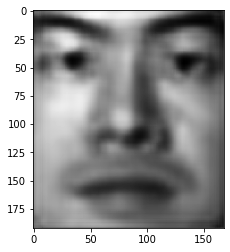

In [17]:
import matplotlib.pyplot as plt
decoded_imgs = autoencoder.predict(X_test)
plt.imshow(decoded_imgs[400])
plt.gray()
plt.show()

## This is the corresponding ground truth image

<function matplotlib.pyplot.show(close=None, block=None)>

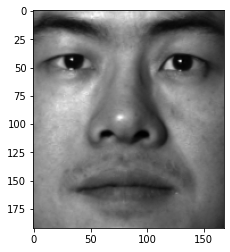

In [18]:
plt.imshow(X_test[400])
plt.gray()
plt.show

# Design and train softmax classifier based on encoded features extracted with Autoencoder

In [19]:
encoder = keras.Model(input_img, encoded)
X_train_ae=encoder.predict(X_train)
X_test_ae=encoder.predict(X_test)

model = tf.keras.models.Sequential([
    #tf.keras.layers.Flatten(input_shape=(7,5,8)),
    tf.keras.layers.Input(shape=(24,21 , 8)),
    tf.keras.layers.Flatten(input_shape=(4032,)),
    #tf.keras.layers.Flatten(input_shape=(768,)),
    tf.keras.layers.Dense(1000,activation='relu'),
    tf.keras.layers.Dense(1000,activation='relu'),

    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(n_classes,activation='softmax') 
])


opt=tf.keras.optimizers.SGD(
    learning_rate=0.01, momentum=0.9
)

model.compile(optimizer=opt,
             loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
             )

#model.summary()
n_epochs=150
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,min_delta=0.02)


hist=model.fit(X_train_ae,y_train,epochs=n_epochs,validation_split=0.2,batch_size=40,callbacks=callback,verbose=0)

19/19 [==============================] - 7s 109ms/step


# Plot accuracy and loss curves of Autoencoder-based softmax classifier 

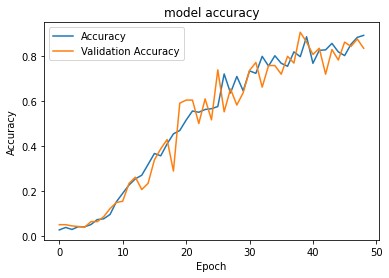

In [20]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()


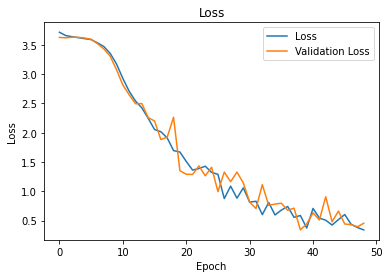

In [21]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()

# Plot confusion matrix ( concerning 10 classes only) of Autoencoder-based softmax classifier

In [22]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
  


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

19/19 [==============================] - 0s 10ms/step


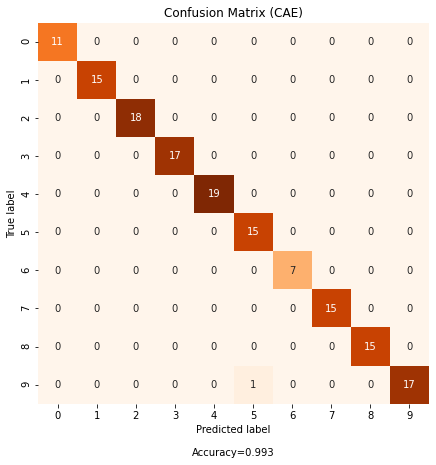

In [42]:
y_o = model.predict(X_test_ae)
y_pred=np.ndarray((X_test_ae.shape[0]))

for i in range(len(y_pred)):
    y_pred[i]=np.argmax(y_o[i])
    
cm=confusion_matrix(y_test, y_pred, labels=range(n_classes))
a=cm[:10,:10]
make_confusion_matrix(a, figsize=(7,7), cbar=False,percent=False,title='Confusion Matrix (CAE)',cmap='Oranges')


# Extract features with PCA

In [48]:
n_components =300

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train_pca.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train_pca)

Extracting the top 300 eigenfaces from 1818 faces


In [49]:
eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train_pca)
X_test_pca = pca.transform(X_test_pca)

Projecting the input data on the eigenfaces orthonormal basis


# Pass features to softmax classifier and train classifier

In [36]:
model_pca = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(n_components,)),
    tf.keras.layers.Dense(1000,activation='relu'),
    tf.keras.layers.Dense(1000,activation='relu'),

    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(n_classes,activation='softmax') 
])



opt=tf.keras.optimizers.SGD(
    learning_rate=0.01, momentum=0.9
)

model_pca.compile(optimizer=opt,
             loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
             )

#model_pca.summary()

#n_epochs=150
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,min_delta=0.02)


hist=model_pca.fit(X_train_pca,y_train,epochs=n_epochs,validation_split=0.2,batch_size=40,callbacks=callback,verbose=0)

# Plot accuracy and loss curves of PCA-based softmax classifier

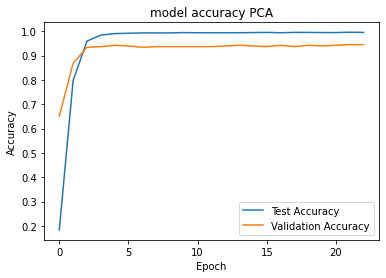

In [37]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
#plt.plot(hist.history['loss'])
#plt.plot(hist.history['val_loss'])
plt.title("model accuracy PCA")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Test Accuracy","Validation Accuracy"])
plt.show()

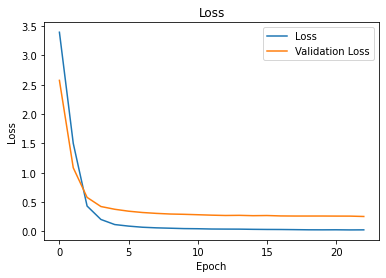

In [38]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()

# Plot confusion matrix ( concerning 10 classes only) of PCA-based softmax classifier

19/19 [==============================] - 0s 5ms/step


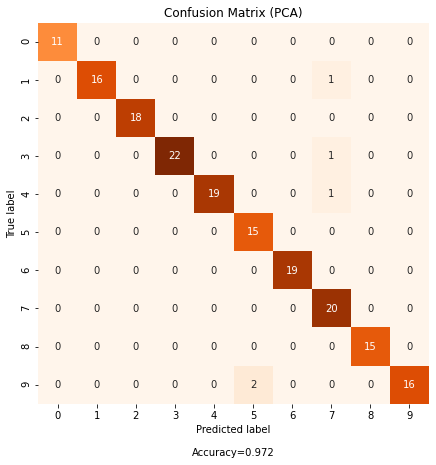

In [41]:
y_o = model_pca.predict(X_test_pca)
y_o.shape

y_pred=np.ndarray((X_test_pca.shape[0]))

for i in range(len(y_pred)):
    y_pred[i]=np.argmax(y_o[i])


cm=confusion_matrix(y_test, y_pred, labels=range(n_classes))
a=cm[:10,:10]
make_confusion_matrix(a, figsize=(7,7), cbar=False,percent=False,title='Confusion Matrix (PCA)',cmap='Oranges')
